In this notebook, I will be modeling EAD (Exposure at Default). This refers to the maximum amount of money a bank can lose, given the borrower defaults. Given the Lending Club Dataset, this refers to the maximum amount investors can lose, should the borrower decide to default. The accurate estimation of EAD helps lenders better understand their potential loss exposure and the allocation of collateral more effectively. For defaulted loans, EAD refers to the **outstanding principal balance** (remaining unpaid amount when borrowers default). Simply put, it just refers to **how much money is still left unpaid at the moment the borrower stops repaying**.

We will be using a **Multiple Linear Regression Model** to model EAD. This is because this belongs to a supervised learning approach, where we are going to predict a continuous variable (outstanding principal balance). Furthermore, it serves as a good and interpretable baseline models, to benchmark against more complex algortihms / challenger models.

The following steps will be executed in this notebook:

1. Data Preparation (Removal of irrelevant variables, Remove Post Loan Origination Features, Derive Target Variables & Features)
2. Feature Engineering (Create Interaction Features)
3. Handling Outliers & Skewness
4. Multicollinearity Handling & & Feature Selection
5. Training MLR Model
6. Inspect Model Diagnostics (F-Test)
7. Model Evaluation

Throughout the above process, we will be quickly training our model, and logging it to inspect model performance throughout the notebook.

# 0. Import Libraries


In [1]:
# === Standard libraries ===

import os
import warnings
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

# === WandB Logging  ===
import wandb

wandb.login(key=os.getenv("WANDB_API_KEY"))

# == Global Functions ==
from functions import *


# === Spark Session & Functions ===
from init_spark import start_spark
import math

spark = start_spark()
from pyspark.sql.functions import (
    col,
    when,
    count,
    desc,
    isnan,
    isnull,
    lit,
    length,
    trim,
    lower,
    upper,
    to_date,
    concat_ws,
    regexp_extract,
    mean,
)
from pyspark.sql.types import (
    StructType,
    StructField,
    StringType,
    DoubleType,
    IntegerType,
    DateType,
    NumericType,
    FloatType,
    LongType,
)


# === Pandas Dataframe & WoE Binning ===
import pandas as pd
from tabulate import tabulate
from optbinning import OptimalBinning
import numpy as np

# == Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# === Machine Learning ===
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler  # MinMaxScaler for normalization
from sklearn.linear_model import LinearRegression


# == Optbinning ==
from optbinning import OptimalPWBinning


# === Load Environment Variables ===
from dotenv import load_dotenv

load_dotenv()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
wandb: Currently logged in as: wlunlun1212 (wlunlun1212-singapore-management-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/lunlun/.netrc
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/18 22:57:27 WARN Utils: Your hostname, Chengs-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 192.168.0.77 instead (on interface en0)
25/0

4.0.0


True

In [2]:
# -----------
#  Constants
# -----------
NOTEBOOK_RUN_NAME = "EAD Model Building"
MODEL_NAME = "MLR Model"

In [3]:
# --------------------
#  Reusable Functions
# --------------------


def winsorise_col_pd(
    df: pd.DataFrame,
    col_name: str,
    operator: str,
    condition_val: float,
    final_val: float,
) -> pd.DataFrame:
    """
    Winsorises a column by replacing values above/below a cutoff with a fixed value.

    Args:
        df (pd.DataFrame): The input DataFrame.
        col_name (str): Column to winsorise.
        operator (str): Condition operator ("<" or ">").
        condition_val (float): Threshold for condition.
        final_val (float): Value to replace with.

    Returns:
        pd.DataFrame: DataFrame with winsorised column.
    """
    print(f"✅ Winsorising column: {col_name} ...")

    if operator == "<":
        df[col_name] = np.where(df[col_name] < condition_val, final_val, df[col_name])
    elif operator == ">":
        df[col_name] = np.where(df[col_name] > condition_val, final_val, df[col_name])
    else:
        raise ValueError("Operator must be '<' or '>'")
    return df


def retain_rows_pd(
    df: pd.DataFrame, col_name: str, condition_val: float, operator: str
) -> pd.DataFrame:
    """
    Retains rows where the column meets the condition.

    Args:
        df (pd.DataFrame): The input DataFrame.
        col_name (str): Column to filter on.
        condition_val (float): Cutoff for condition.
        operator (str): One of '<=', '<', '>', '>='.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    if operator == "<=":
        return df[df[col_name] <= condition_val]
    elif operator == "<":
        return df[df[col_name] < condition_val]
    elif operator == ">":
        return df[df[col_name] > condition_val]
    elif operator == ">=":
        return df[df[col_name] >= condition_val]
    else:
        raise ValueError("Operator must be one of '<=', '<', '>', '>='")


def compute_outlier_pct_pd(s: pd.Series) -> float:
    """Return % of outliers in a pandas Series using IQR rule."""
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return 0.0
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outlier_count = ((s < lower) | (s > upper)).sum()
    return outlier_count / len(s) * 100


def inspect_outliers_pd(
    df: pd.DataFrame,
    columns: list,
    sample_size: int = 5,
    method: str = "iqr",  # "iqr" or "percentile"
    lower_pct: float = 0.01,  # used if method="percentile"
    upper_pct: float = 0.99,  # used if method="percentile"
):
    """
    Inspect outliers for a list of columns in a pandas DataFrame.

    Prints:
      - bounds used (IQR or percentile)
      - outlier count and %
      - top and bottom outlier samples

    Notes:
      - Non-numeric values are coerced to NaN.
      - Bounds are computed on non-null values only.
    """
    for col in columns:
        try:
            print(f"\n📊 Inspecting Outliers for Column: `{col}`")

            # Work on a numeric, non-null Series
            s = pd.to_numeric(df[col], errors="coerce").dropna()
            valid_n = len(s)
            total_n = len(df)
            if valid_n == 0:
                print("⚠️ No numeric/valid data; skipping.")
                continue

            if method.lower() == "iqr":
                q1, q3 = s.quantile([0.25, 0.75])
                iqr = q3 - q1
                lower = q1 - 1.5 * iqr
                upper = q3 + 1.5 * iqr
                print(f"IQR Method | Q1={q1:.6g}, Q3={q3:.6g}, IQR={iqr:.6g}")
                print(f"Lower Bound={lower:.6g}, Upper Bound={upper:.6g}")

            elif method.lower() == "percentile":
                q_low, q_high = s.quantile([lower_pct, upper_pct])
                lower, upper = float(q_low), float(q_high)
                max_val = s.max()
                print(
                    f"Percentile Method | "
                    f"Lower (p{int(lower_pct*100)})={lower:.6g}, "
                    f"Upper (p{int(upper_pct*100)})={upper:.6g}"
                )
                print(f"🔝 Max({col}) = {max_val:.6g}")
                # show a few rows equal to max
                at_max = s[s == max_val].head(min(sample_size, 5))
                if len(at_max) > 0:
                    print("Rows at max value:")
                    print(at_max)

            else:
                print(f"❌ Unknown method `{method}`. Skipping `{col}`.")
                continue

            # Identify outliers
            mask_out = (s < lower) | (s > upper)
            outliers = s[mask_out]
            outlier_count = len(outliers)
            outlier_pct = round(outlier_count / valid_n * 100, 2)

            print(f"Outlier Count: {outlier_count} ({outlier_pct}% of valid {valid_n})")

            # Top outliers
            if outlier_count > 0:
                print(f"\n🔼 Top Outliers (>{upper:.6g}):")
                print(outliers.sort_values(ascending=False).head(sample_size))

                # Bottom outliers
                print(f"\n🔽 Bottom Outliers (<{lower:.6g}):")
                print(outliers.sort_values(ascending=True).head(sample_size))
            else:
                print("✅ No outliers by the chosen rule.")

        except Exception as e:
            print(f"❌ Could not process column `{col}`: {e}")


def plot_feature_distribution(
    df, feature_list, bins=50, kde=False, cols=3, figsize=(18, 5)
):
    rows = math.ceil(len(feature_list) / cols)
    plt.figure(figsize=(figsize[0], figsize[1] * rows))

    for i, col in enumerate(feature_list):
        ax = plt.subplot(rows, cols, i + 1)
        sns.histplot(
            df[col],
            bins=bins,
            kde=kde,
            ax=ax,
        )
        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=9)
        ax.set_ylabel("Count", fontsize=9)

    plt.tight_layout()
    plt.show()


# == Skewness Transformations ==
def apply_log1p(df: pd.DataFrame, col: str) -> pd.DataFrame:
    """
    Apply log1p (log(1+x)) transformation to a column in a DataFrame.
    Clips all negative values to 0 before transforming.

    Args:
        df (pd.DataFrame): input DataFrame
        col (str): column name to transform
        new_col (str): name of new column to save the log1p-transformed values

    Returns:
        pd.DataFrame: DataFrame with new log1p column added
    """
    safe_col = df[col].clip(lower=0)  # ensure no negatives
    df[f"log1p_{col}"] = np.log1p(safe_col)  # log(1+x)
    return df


def apply_logit(df: pd.DataFrame, col: str, is_proportion=False) -> pd.DataFrame:
    """
    Apply logit transformation to a column in a DataFrame.

    Args:
        df (pd.DataFrame): input DataFrame
        col (str): column name to transform
        new_col (str): name of new column to save the logit-transformed values
        is_proportion (bool): if False (This is in absolute percentage ), divide values by 100 first

    Returns:
        pd.DataFrame: DataFrame with new logit column added
    """
    x = df[col].astype(float)

    # If column is percentage (0–100), convert to proportion (0–1)
    if not is_proportion:
        x = x / 100.0

    # Clip to avoid log(0) or division by zero
    x_clipped = np.clip(x, 1e-6, 1 - 1e-6)

    # Apply logit transform
    df[f"logit_{col}"] = np.log(x_clipped / (1 - x_clipped))

    return df


def yeo_johnson_transform(df, cols):
    """
    Apply Yeo-Johnson transformation to selected columns in a pandas DataFrame.
    Prints skewness before and after for each column.
    """
    pt = PowerTransformer(method="yeo-johnson", standardize=False)

    for col in cols:
        print(f"\n📊 Column: {col}")
        print("Skewness before:", skew(df[col].dropna()))

        df["yeojohnson_" + col] = pt.fit_transform(df[[col]])

        print("Skewness after:", skew(df["yeojohnson_" + col].dropna()))

    return df

In [4]:
# == Remove all existing runs every time I run this notebook ==

api = wandb.Api()
for run in api.runs(
    f"wlunlun1212-singapore-management-university/Credit Risk Modeling"
):
    if run.group == NOTEBOOK_RUN_NAME:
        run.delete()

In [5]:
df = spark.read.format("delta").load("../data/gold/medallion_cleaned_lc_data")

df.limit(10).toPandas()

25/08/18 22:57:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,credit_history_years,fico_score
0,87704389,1000.0,1000.0,36,10.49,32.50,B,2,MORTGAGE,39975.0,...,100.0,0.0,0.0,0.0,146014.0,60931.0,8300.0,70423.0,10,762.0
1,88862675,4800.0,4800.0,36,18.99,175.93,D,6,MORTGAGE,132000.0,...,78.6,0.0,0.0,0.0,314046.0,53279.0,500.0,54636.0,17,662.0
2,85636448,4075.0,4075.0,36,14.49,140.25,C,1,RENT,12000.0,...,100.0,0.0,0.0,0.0,27142.0,18772.0,5200.0,20342.0,4,752.0
3,88012886,23975.0,23975.0,60,15.59,577.82,C,2,RENT,89999.0,...,95.2,0.0,0.0,0.0,48652.0,14397.0,31500.0,12684.0,18,732.0
4,87989149,8000.0,8000.0,36,12.79,268.75,C,10,OWN,30000.0,...,100.0,20.0,1.0,0.0,55262.0,29807.0,11600.0,34562.0,9,707.0
5,85582885,5600.0,5600.0,36,12.79,188.13,C,10,MORTGAGE,109000.0,...,81.2,0.0,0.0,0.0,421855.0,50608.0,3000.0,58902.0,17,702.0
6,88494037,6000.0,6000.0,36,10.49,194.99,B,0,OWN,55000.0,...,100.0,0.0,0.0,0.0,27352.0,7421.0,19500.0,7852.0,15,807.0
7,88143505,24000.0,24000.0,60,15.59,578.42,C,10,MORTGAGE,65000.0,...,94.7,50.0,0.0,0.0,310036.0,38795.0,14000.0,28679.0,13,682.0
8,86216472,3200.0,3200.0,36,9.49,102.50,B,6,MORTGAGE,72000.0,...,94.3,0.0,0.0,0.0,112899.0,60713.0,4000.0,57816.0,12,747.0
9,87624578,3600.0,3600.0,36,8.59,113.80,A,0,RENT,70000.0,...,56.2,100.0,0.0,0.0,63980.0,40699.0,7500.0,54780.0,30,692.0


In [6]:
sorted(df.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'application_type',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'credit_history_years',
 'default_status',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'fico_score',
 'funded_amnt',
 'grade',
 'home_ownership',
 'id',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'issue_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'last_pymnt_amnt',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'open_acc',
 'out_prncp',
 '

# 1. Data Preparation

We will now be preparing our dataset. We shall first determine our target variable (Credit Conversion Factor), which just refers to the proportion of principal sum still outstanding (unpaid). Since EAD is defined as the amount owed / left unpaid the exact moment a borrower defaults, we shall only limit our dataset to defaulted loans. This is because performing loans doesn't have EAD. Including performing loans in our dataset will make our regression model see a lot of 0s, biasing our model. As such, our model should only be trained on actual default cases, in order to accurately predict for all cases, the maximum possible monetary loss given a loan / borrower defaults, so Lending Club can make accurate decisions on risk management.


In [7]:
# --------------------------------------
# Obtain Credit Conversion Factor (CCF)
# --------------------------------------

# == 1) Audit bad funded_amnt rows ==
total_rows = df.count()
bad_rows = df.filter((col("funded_amnt").isNull()) | (col("funded_amnt") <= 0)).count()

print(f"Total rows: {total_rows:,}")
print(f"Rows with funded_amnt <= 0 or null: {bad_rows:,} ({bad_rows/total_rows:.2%})")

# == 2) Drop bad rows ==
df = df.filter(col("funded_amnt") > 0)

# ==  3) Compute CCF (and clamp negatives to 0) -> Minimum exposure at default should be 0, even when recoveries > principal ==
df = df.withColumn(
    "ccf", (col("funded_amnt") - col("total_rec_prncp")) / col("funded_amnt")
).withColumn("ccf", when(col("ccf") < 0, 0).otherwise(col("ccf")))

Total rows: 1,339,155
Rows with funded_amnt <= 0 or null: 0 (0.00%)


In [8]:
# --------------------------------------------------------
# Removal of Post Loan Origination Features (EAD Modeling)
# --------------------------------------------------------
vars_to_drop = [
    # Identifiers
    "id",
    # Target/outcome
    "default_status",  # PD target, not predictor
    # Post-origination performance
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_d",
    "last_pymnt_amnt",
    "last_credit_pull_d",
    "next_pymnt_d",
    "last_fico_range_high",
    "last_fico_range_low",
]


# Keep only columns that actually exist before dropping (avoids errors)
vars_to_drop_existing = [c for c in vars_to_drop if c in df.columns]
df = df.drop(*vars_to_drop_existing)

for col_name in vars_to_drop_existing:
    assert col_name not in df.columns, f"{col_name} was not dropped"

print("Dropped columns:", vars_to_drop_existing)
print(f"Final row count: {df.count():,}")

Dropped columns: ['id', 'default_status', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low']
Final row count: 1,339,155


In [9]:
# == Quick Base Model Performance Check ==
# run_mlr_model_checkpoint()

# 2. Feature Engineering

Now I will be doing feature engineering for the EAD model. This involves creating meaningful features from the data that can help the model better predict exposure at default. This means creating features that help the model predict how much exposure the bank will have if the borrower defaults. By capturing these behaviors and account details through carefully designed features, the model can better estimate the expected exposure at default. Good feature engineering for EAD is crucial because it reflects the dynamics of credit usage leading up to default, which directly impacts risk management practices utilised by Lending Club.


In [10]:
def add_rowwise_features(df):
    eps = lit(1e-6)
    out = df

    out = out.withColumn(
        "installment/annual_inc_per_month",  # Higher proportion of instalment per month signifies slower repayment, higher EAD
        col("installment") / (col("annual_inc") / 12 + eps),
    )

    out = out.withColumn(
        "bc_open_to_buy/total_bc_limit",  # unused credit buffer (which should be factored in, since borrowers tend to use up credit limit before defaulting)
        col("bc_open_to_buy") / (col("total_bc_limit") + lit(1.0)),
    )

    out = out.withColumn(
        "bc_util_x_total_bc_limit",  # Magnitude of bankcard leverage
        col("bc_util") * col("total_bc_limit"),
    )

    out = out.withColumn(
        "revol_util_x_total_rev_hi_lim",  # Absolute amount of revolving credit used
        col("revol_util") * col("total_rev_hi_lim"),
    )

    out = out.withColumn(
        "fico_score_x_dti",  # Debt burden effect varies with credit quality
        col("fico_score") * col("dti"),
    )

    out = out.withColumn(  # short credit history and many accounts causes amount to be repaid upon default to be higher
        "credit_history_years_x_total_acc",
        col("credit_history_years") * col("total_acc"),
    )

    out = out.withColumn(
        "int_rate_x_term",  # longer term, yet higher interest -> pay back loan slowly -> prorpotion yet to be paid higher
        col("int_rate") * col("term"),
    )

    out = out.withColumn(
        "dti_x_annual_inc",  # low income, high DTI borrowers have fewer buffers -> potential for higher EAD
        col("dti") * col("annual_inc"),
    )

    out = out.withColumn(
        "revol_util_x_num_rev_accts",  # borrowers with many maxed out lines -> likely to have less capacity to repay -> higher EAD
        col("revol_util") * col("num_rev_accts"),
    )

    out = out.withColumn(
        "inq_last_6mths_x_fico_score",  # many recent inquiries & low fico score likely to default earlier -> larger proportion of loan left unpaid
        col("inq_last_6mths") * col("fico_score"),
    )

    out = out.withColumn(
        "emp_length_x_annual_inc",  # short employed history and low annual income default sooner -> higher EAD
        col("emp_length") * col("annual_inc"),
    )

    out = out.withColumn(
        "mort_acc_x_dti",  # many mortgages applied, with high dti signfies lack of financial planning -> default earlier -> EAD higher
        col("mort_acc") * col("dti"),
    )

    return out


df_inter_features = add_rowwise_features(df)

In [11]:
df_inter_features.limit(10).toPandas()
print(f"Old Number of Columns: {len(df.columns)}")
print(f"New Number of Columns: {len(df_inter_features.columns)}")

Old Number of Columns: 64
New Number of Columns: 76


In [12]:
df2 = df_inter_features

In [13]:
df2.columns

['loan_amnt',
 'funded_amnt',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75

# 3. Outlier & Skewness Handling

Now I will handle skewness in the data. Many financial variables, like balances and limits, can be highly skewed, which can affect model performance in EAD modeling. Transforming these variables (for example, with log or Box-Cox) helps to stabilize their distributions and make the model more reliable.

### 3.1 Train - Test Split


In [14]:
# -------------------------------------------------
# Convert to Pandas (For integration with SKLEARN)
# -------------------------------------------------

# Enable Arrow for speed
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
pdf2 = (
    df2.toPandas()
)  # 1.3M rows is typically fine on a 16–32GB machine with a dozen cols

In [15]:
# -----------
#  OOT Split
# -----------
pdf2_sorted = pdf2.sort_values("issue_d", ascending=True)

In [16]:
# -------------------------------------
#  Get Train Dataset, and Test Dataset
# -------------------------------------
split_idx = int(len(pdf2_sorted) * 0.8)
train_pdf2 = pdf2_sorted.iloc[:split_idx]
test_pdf2 = pdf2_sorted.iloc[split_idx:]

display(train_pdf2.head())
display(test_pdf2.head())

,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,bc_util_x_total_bc_limit,revol_util_x_total_rev_hi_lim,fico_score_x_dti,credit_history_years_x_total_acc,int_rate_x_term,dti_x_annual_inc,revol_util_x_num_rev_accts,inq_last_6mths_x_fico_score,emp_length_x_annual_inc,mort_acc_x_dti
665474,7500.0,7500.0,36,13.75,255.43,E,0,OWN,22000.0,Not Verified,...,940500.0,1236000.0,9459.98,24,495.00,314380.0,669.5,0.0,0.0,14.29
665495,3500.0,3500.0,36,9.96,112.87,B,0,RENT,13500.0,Not Verified,...,940500.0,986400.0,11705.28,64,358.56,221940.0,534.3,712.0,0.0,16.44
665504,12250.0,12250.0,36,10.59,398.69,C,3,RENT,60000.0,Not Verified,...,940500.0,194400.0,12788.64,912,381.24,1027200.0,105.3,1494.0,180000.0,17.12
665503,5000.0,5000.0,36,9.33,159.77,B,2,MORTGAGE,180000.0,Not Verified,...,940500.0,940800.0,8553.81,456,335.88,2147400.0,509.6,717.0,360000.0,11.93
665502,5300.0,5300.0,36,8.38,167.02,A,7,MORTGAGE,74000.0,Not Verified,...,940500.0,345600.0,11452.89,435,301.68,1063380.0,187.2,0.0,518000.0,14.37


,loan_amnt,funded_amnt,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,...,bc_util_x_total_bc_limit,revol_util_x_total_rev_hi_lim,fico_score_x_dti,credit_history_years_x_total_acc,int_rate_x_term,dti_x_annual_inc,revol_util_x_num_rev_accts,inq_last_6mths_x_fico_score,emp_length_x_annual_inc,mort_acc_x_dti
53967,19000.0,19000.0,36,10.49,617.46,B,6,RENT,70000.00,Source Verified,...,306000.0,345840.0,11298.98,420,377.64,1.185800e+06,314.4,0.0,420000.00,0.00
53968,12000.0,12000.0,36,11.49,395.66,B,8,MORTGAGE,60000.00,Source Verified,...,85000.0,85000.0,1536.24,275,413.64,1.332000e+05,212.5,0.0,480000.00,2.22
53969,7000.0,7000.0,36,6.99,216.11,A,6,OWN,36120.72,Not Verified,...,218080.0,218000.0,10831.38,143,251.64,5.035228e+05,90.0,0.0,216724.32,0.00
53970,4950.0,4950.0,36,12.79,166.29,C,6,RENT,13800.00,Verified,...,725900.0,725900.0,7753.24,180,460.44,1.451760e+05,427.0,737.0,82800.00,0.00
53971,25900.0,25900.0,36,13.49,878.80,C,6,MORTGAGE,54000.00,Verified,...,839800.0,839520.0,3544.84,340,485.64,2.386800e+05,187.2,802.0,324000.00,17.68


### 3.2 Outlier Inspection


In [17]:
# ----------------------------------------------------------------
# Identify Columns that need Action: Find outliers % per column
# ----------------------------------------------------------------

numeric_df5 = train_pdf2.select_dtypes(include=[np.number])

outliers_dict = {}
for col in numeric_df5.columns:
    outlier_pct = compute_outlier_pct_pd(numeric_df5[col])
    if outlier_pct > 0:
        outliers_dict[col] = outlier_pct

print("❌ Outlier Percentage by Feature (sorted):")
for k, v in sorted(outliers_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{k}: {round(v, 2)}%")

❌ Outlier Percentage by Feature (sorted):
term: 24.11%
num_accts_ever_120_pd: 22.16%
ccf: 19.66%
delinq_2yrs: 19.44%
pub_rec: 16.52%
tot_coll_amt: 14.13%
pub_rec_bankruptcies: 11.9%
mths_since_recent_bc: 9.84%
bc_open_to_buy: 9.41%
mo_sin_old_il_acct: 8.7%
mo_sin_rcnt_rev_tl_op: 8.31%
mo_sin_rcnt_tl: 7.24%
pct_tl_nvr_dlq: 6.71%
total_bc_limit: 6.55%
total_rev_hi_lim: 6.4%
total_bal_ex_mort: 6.16%
bc_util_x_total_bc_limit: 6.01%
avg_cur_bal: 5.85%
revol_bal: 5.77%
inq_last_6mths: 5.69%
inq_last_6mths_x_fico_score: 5.69%
int_rate_x_term: 5.68%
num_il_tl: 5.63%
total_il_high_credit_limit: 5.56%
revol_util_x_total_rev_hi_lim: 5.55%
num_tl_90g_dpd_24m: 5.49%
num_actv_rev_tl: 5.37%
num_rev_tl_bal_gt_0: 5.08%
mort_acc_x_dti: 4.99%
annual_inc: 4.62%
num_bc_tl: 4.54%
num_bc_sats: 4.01%
tot_cur_bal: 4.0%
credit_history_years_x_total_acc: 3.97%
tot_hi_cred_lim: 3.96%
num_op_rev_tl: 3.86%
mths_since_recent_inq: 3.82%
dti_x_annual_inc: 3.62%
mo_sin_old_rev_tl_op: 3.56%
open_acc: 3.29%
tax_liens: 3.

In [18]:
# ----------------------
# Check Outlier Values
# ----------------------
outlier_columns = list(outliers_dict.keys())
inspect_outliers_pd(df=train_pdf2, columns=outlier_columns, method="iqr")


📊 Inspecting Outliers for Column: `loan_amnt`
IQR Method | Q1=8000, Q3=20000, IQR=12000
Lower Bound=-10000, Upper Bound=38000
Outlier Count: 1580 (0.15% of valid 1071324)

🔼 Top Outliers (>38000):
394578    40000.0
475588    40000.0
477384    40000.0
477751    40000.0
477743    40000.0
Name: loan_amnt, dtype: float64

🔽 Bottom Outliers (<-10000):
484834    38100.0
31902     38150.0
402151    38150.0
47674     38150.0
45451     38175.0
Name: loan_amnt, dtype: float64

📊 Inspecting Outliers for Column: `funded_amnt`
IQR Method | Q1=8000, Q3=20000, IQR=12000
Lower Bound=-10000, Upper Bound=38000
Outlier Count: 1580 (0.15% of valid 1071324)

🔼 Top Outliers (>38000):
394578    40000.0
475588    40000.0
477384    40000.0
477751    40000.0
477743    40000.0
Name: funded_amnt, dtype: float64

🔽 Bottom Outliers (<-10000):
484834    38100.0
31902     38150.0
402151    38150.0
47674     38150.0
45451     38175.0
Name: funded_amnt, dtype: float64

📊 Inspecting Outliers for Column: `term`
IQR Meth

In [19]:
# --------------------------------------------
# Apply business rules & remove placeholders
# --------------------------------------------

# == DTI Outlier Handling ==
train_pdf2 = retain_rows_pd(train_pdf2, "dti", 120, "<=")  # Drop rows where dti > 120
train_pdf2 = winsorise_col_pd(
    train_pdf2, "dti", ">", 100, 100
)  # Winsorise dti > 100 to 100


# == Only allow fico_scores between 300 and 850 ==
train_pdf2 = retain_rows_pd(train_pdf2, "fico_score", 300, ">")
train_pdf2 = retain_rows_pd(train_pdf2, "fico_score", 850, "<")


# == total_rev_hi_lim ==
train_pdf2 = train_pdf2[train_pdf2["total_rev_hi_lim"] < 9_999_999.0]

# == mo_sin_old_* (drop likely placeholders) ==
train_pdf2 = train_pdf2[train_pdf2["mo_sin_old_il_acct"] < 999]
train_pdf2 = train_pdf2[train_pdf2["mo_sin_old_rev_tl_op"] < 999]

# == high credit limit ==
train_pdf2 = train_pdf2[train_pdf2["tot_hi_cred_lim"] < 9_999_999.0]

✅ Winsorising column: dti ...


In [20]:
# ---------------------------------------------------------------------
# Detect extreme values (may have disproportionate influence on model)
# ---------------------------------------------------------------------
inspect_outliers_pd(df=train_pdf2, columns=outlier_columns, method="percentile")


📊 Inspecting Outliers for Column: `loan_amnt`
Percentile Method | Lower (p1)=1775, Upper (p99)=35000
🔝 Max(loan_amnt) = 40000
Rows at max value:
394578    40000.0
394462    40000.0
394721    40000.0
394654    40000.0
394192    40000.0
Name: loan_amnt, dtype: float64
Outlier Count: 12776 (1.19% of valid 1071266)

🔼 Top Outliers (>35000):
36852     40000.0
374670    40000.0
459883    40000.0
396815    40000.0
29031     40000.0
Name: loan_amnt, dtype: float64

🔽 Bottom Outliers (<1775):
666154    500.0
665613    500.0
665814    500.0
665866    500.0
665804    500.0
Name: loan_amnt, dtype: float64

📊 Inspecting Outliers for Column: `funded_amnt`
Percentile Method | Lower (p1)=1775, Upper (p99)=35000
🔝 Max(funded_amnt) = 40000
Rows at max value:
394578    40000.0
394462    40000.0
394721    40000.0
394654    40000.0
394192    40000.0
Name: funded_amnt, dtype: float64
Outlier Count: 12789 (1.19% of valid 1071266)

🔼 Top Outliers (>35000):
406786    40000.0
28278     40000.0
387536    40000.

In [21]:
# ----------------------------------------------------
# Winsorise at 99% to reduce impact of extreme values
# ----------------------------------------------------

required_winsorization = [
    "annual_inc",
    "dti",
    "revol_bal",
    "tot_coll_amt",
    "tot_cur_bal",
    "total_rev_hi_lim",
    "avg_cur_bal",
    "bc_open_to_buy",
    "bc_util",
    "tot_hi_cred_lim",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
    "fico_score",
    # interaction features
    "installment/annual_inc_per_month",
    "bc_open_to_buy/total_bc_limit",
    "bc_util_x_total_bc_limit",
    "revol_util_x_total_rev_hi_lim",
    "fico_score_x_dti",
    "credit_history_years_x_total_acc",
    "int_rate_x_term",
    "dti_x_annual_inc",
    "revol_util_x_num_rev_accts",
    "inq_last_6mths_x_fico_score",
    "emp_length_x_annual_inc",
    "mort_acc_x_dti",
]

for column in required_winsorization:
    p1 = train_pdf2[column].quantile(0.01)
    p99 = train_pdf2[column].quantile(0.99)
    max_val = train_pdf2[column].max()
    # Only winsorize if gap is significant (e.g., >10% of p99)
    if (max_val - p99) > (0.1 * p99):
        train_pdf2[column] = train_pdf2[column].clip(lower=p1, upper=p99)
    else:
        train_pdf2[column] = train_pdf2[column]  # no change

### 3.3 Transformation Execution

We shall now examine skewness and transform highly skewed variables by log transforming / logit transformation / box-cox based on the following workflow diagram I have compiled in Draw.IO. Should the 1st layer of transformation not work, fallbacks will be Yeo Johnson Transformation, then Quantile Binning thereafter. Such a skewness handling workflow is important to ensure extreme values in our dataset will not cause our model to be overly sensitive to extreme values.

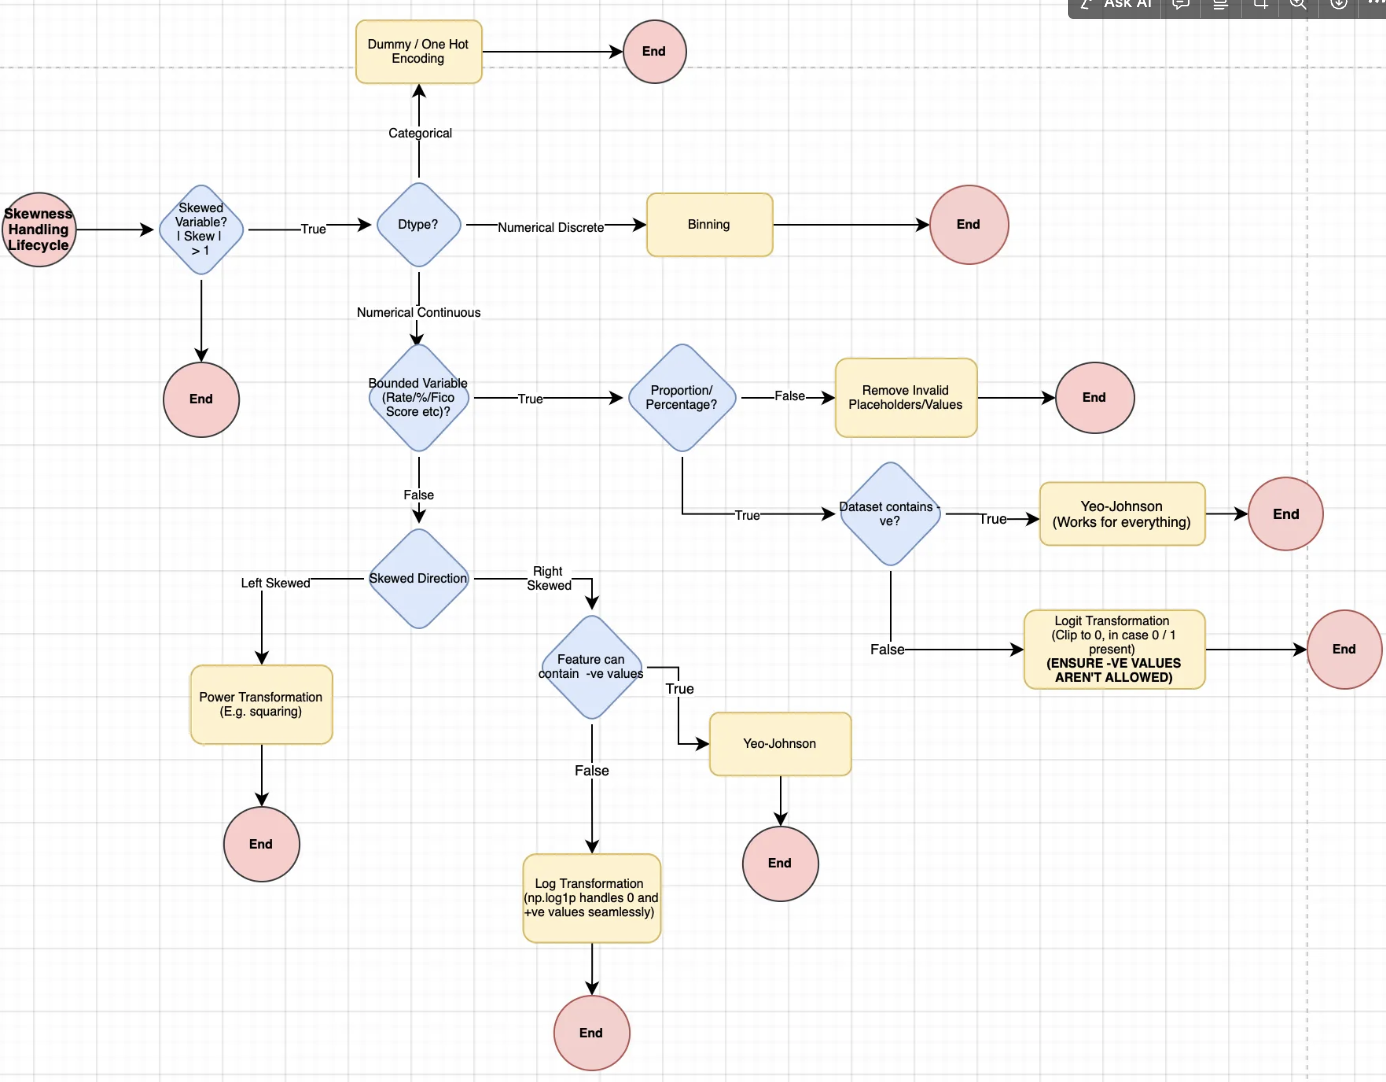


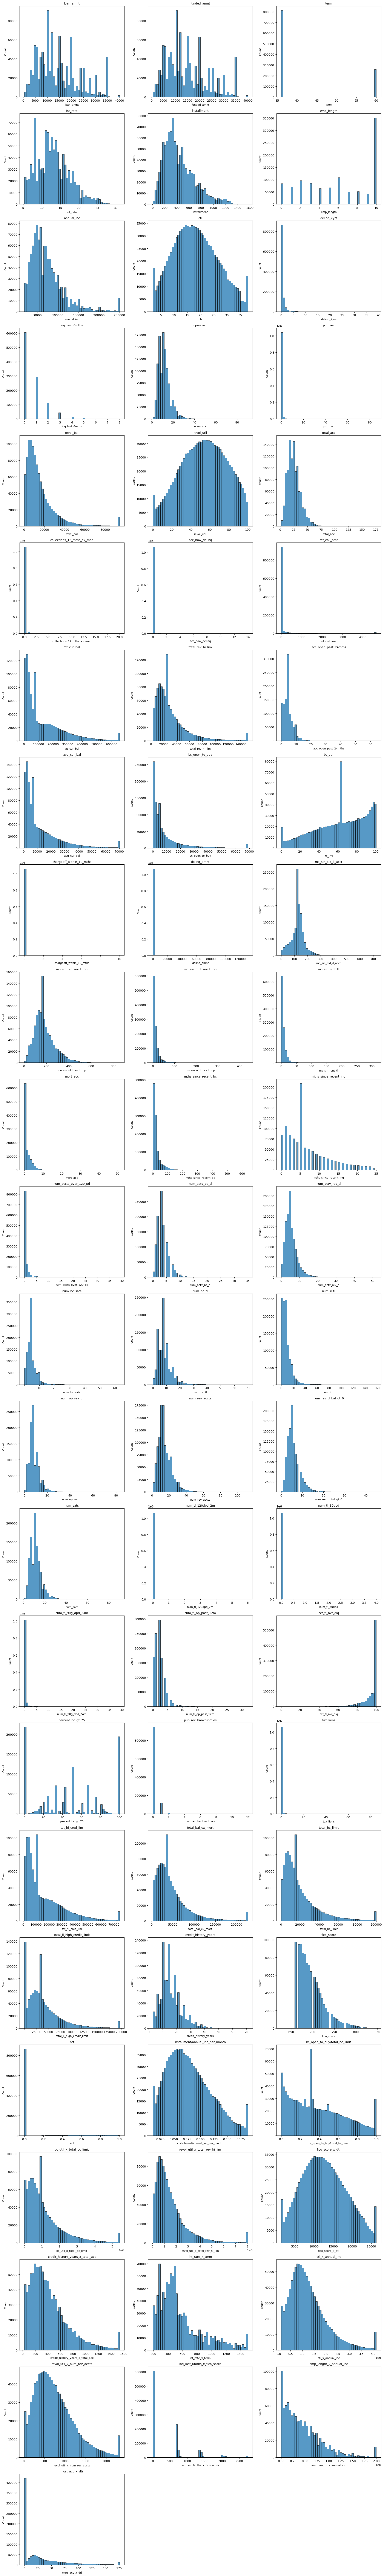

In [22]:
# == Inspect Distribution / Skewness ==
# == identify columns normal vs skewed & need transformation ==

numeric_cols = train_pdf2.select_dtypes(include="number").columns.tolist()
plot_feature_distribution(train_pdf2, numeric_cols)

In [23]:
# == Inspect Numerical Skewness ==
import pandas as pd
from IPython.display import HTML

# 1. Pick only numeric columns
numeric_cols = sorted(train_pdf2.select_dtypes(include="number").columns)

# 2. Compute skewness for each numeric column
skewness_dict = train_pdf2[numeric_cols].skew()

# 3. Display skewness (as DataFrame for compatibility with .show())
skew_df = pd.DataFrame(skewness_dict, columns=["skewness"])

# filtered = skew_df.loc[abs(skew_df["skewness"]) < 0.5, :]

# Example: Show transposed DataFrame scrollable
html = f"""
<div style="height:300px;overflow:auto;border:1px solid #ccc">
    {skew_df.to_html()}
</div>
"""
display(HTML(html))

,skewness
acc_now_delinq,21.749558
acc_open_past_24mths,1.406705
annual_inc,1.729791
avg_cur_bal,1.957270
bc_open_to_buy,2.614056
bc_open_to_buy/total_bc_limit,0.532315
bc_util,-0.471889
bc_util_x_total_bc_limit,1.775308
ccf,1.904219
chargeoff_within_12_mths,17.537704


In [24]:
# == Bounded Variables ==
bounded_cols = ["fico_score", "int_rate"]


# == Bounded Variables (Proportion/Percentage) -> Logit Transformation (Clipping just in case 0 / 1 appears) ==
proportions_pct_features_logit = [
    # "installment/annual_inc_per_month",  # skewness of 0.56 is ok
    "pct_tl_nvr_dlq",
]

# == Unbounded Continuous Variables (Have Positives Only -> np.log1p() works... ==
right_skewed_log_transform_features = [
    "annual_inc",
    "avg_cur_bal",
    "bc_open_to_buy/total_bc_limit",
    "bc_util_x_total_bc_limit",
    "bc_open_to_buy",
    "credit_history_years",
    "credit_history_years_x_total_acc",
    "dti_x_annual_inc",
    "emp_length_x_annual_inc",
    "funded_amnt",
    "installment",
    "inq_last_6mths_x_fico_score",
    "int_rate_x_term",
    "mort_acc_x_dti",
    "loan_amnt",
    "tot_hi_cred_lim",
    "revol_bal",
    "revol_util_x_num_rev_accts",
    "revol_util_x_total_rev_hi_lim",
    "tot_coll_amt",
    "tot_cur_bal",
    "total_bal_ex_mort",
    "total_bc_limit",
    "total_il_high_credit_limit",
    "total_rev_hi_lim",
]


# == Discrete Variables ==
skewed_discrete_features = [
    "acc_now_delinq",
    "acc_open_past_24mths",
    "chargeoff_within_12_mths",
    "collections_12_mths_ex_med",
    "delinq_2yrs",
    "inq_last_6mths",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_accts_ever_120_pd",
    "num_actv_bc_tl",
    "num_actv_rev_tl",
    "num_bc_sats",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_rev_tl_bal_gt_0",
    "num_sats",
    "num_tl_120dpd_2m",
    "num_tl_30dpd",
    "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m",
    "open_acc",
    "pub_rec",
    "pub_rec_bankruptcies",
    "tax_liens",
    "term",
    "total_acc",
]

In [25]:
# --------------------------------------------------------
#  Get Log Transform Right Skewed Features on Train
# --------------------------------------------------------
train_pdf2_log_tx = train_pdf2
for feature in right_skewed_log_transform_features:
    train_pdf2_log_tx = apply_log1p(train_pdf2_log_tx, feature)

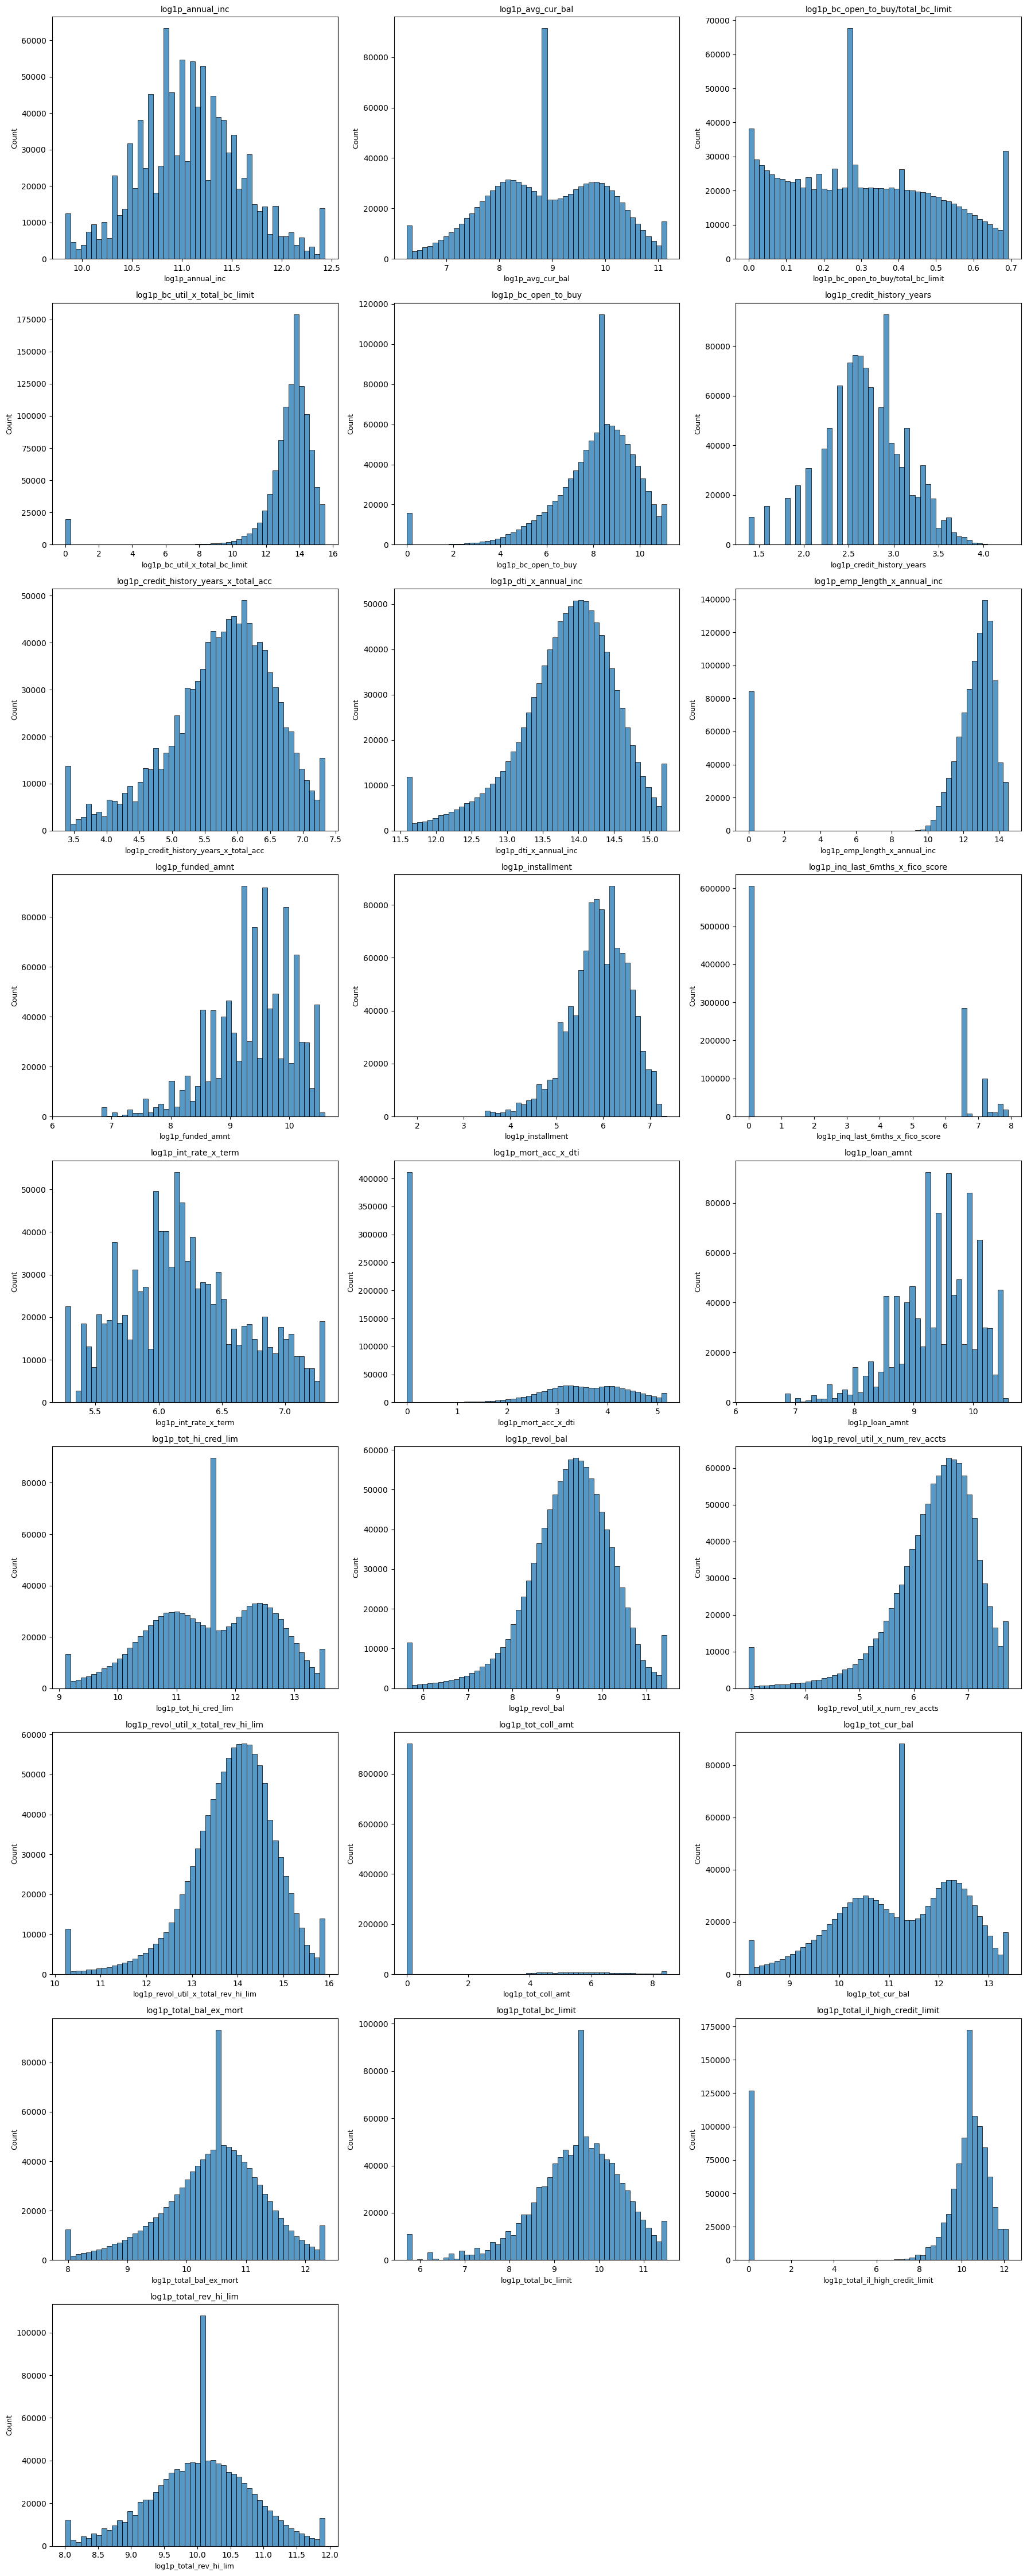

In [26]:
# --------------------------------------------------------
#  Inspect Distribution of Log Transformed Features
# --------------------------------------------------------
log_features = [f"log1p_{feature}" for feature in right_skewed_log_transform_features]
plot_feature_distribution(train_pdf2_log_tx, log_features)

In [27]:
# ----------------------------------------------------------------------
#  Inspect Numerical Skewness of Log Transformed Features (B4 VS AFTER)
# ----------------------------------------------------------------------

skewness_b4_log_tx = pd.DataFrame(
    train_pdf2[right_skewed_log_transform_features].skew(), columns=["skewness_b4"]
)
skewness_aft_log_tx = pd.DataFrame(
    train_pdf2_log_tx[log_features].skew(), columns=["skewness_aft"]
)
skewness_aft_log_tx.index = skewness_aft_log_tx.index.str.replace("log1p_", "")
merged_df = pd.merge(
    skewness_b4_log_tx, skewness_aft_log_tx, left_index=True, right_index=True
)
merged_df

,skewness_b4,skewness_aft
annual_inc,1.729791,0.110484
avg_cur_bal,1.957270,-0.121819
bc_open_to_buy/total_bc_limit,0.532315,0.241140
bc_util_x_total_bc_limit,1.775308,-4.677525
bc_open_to_buy,2.614056,-1.555532
credit_history_years,1.082306,-0.302123
credit_history_years_x_total_acc,1.322109,-0.626522
dti_x_annual_inc,1.207994,-0.712711
emp_length_x_annual_inc,1.371898,-2.802704
funded_amnt,0.746137,-0.660242


In [28]:
# == Obtain all columns which passed skewness check & Drop untransformed columns ==
passed_log_tx_cols = merged_df.index[abs(merged_df["skewness_aft"]) < 1]
train_pdf2_log_tx = train_pdf2_log_tx.drop(columns=passed_log_tx_cols)

In [29]:
# ------------------------------------------------------------
#  Yeo Johnson on Log Transformation Failures (Skewness Check)
# -------------------------------------------------------------

further_tx_features = [
    "bc_util_x_total_bc_limit",
    "bc_open_to_buy",
    "emp_length_x_annual_inc",
    "revol_util_x_num_rev_accts",
    "tot_coll_amt",
    "total_il_high_credit_limit",
    "delinq_amnt",
]

# == Drop columns which failed skewness check after log transformation ==
train_pdf2_log_tx = train_pdf2_log_tx.drop(
    columns=[
        "log1p_bc_util_x_total_bc_limit",
        "log1p_bc_open_to_buy",
        "log1p_emp_length_x_annual_inc",
        "log1p_revol_util_x_num_rev_accts",
        "log1p_tot_coll_amt",
        "log1p_total_il_high_credit_limit",
    ]
)


train_pdf2_log_tx = yeo_johnson_transform(train_pdf2_log_tx, further_tx_features)


📊 Column: bc_util_x_total_bc_limit
Skewness before: 1.7753059051410511
Skewness after: -0.07888332347211724

📊 Column: bc_open_to_buy
Skewness before: 2.6140521231824088
Skewness after: -0.00712625027279627

📊 Column: emp_length_x_annual_inc
Skewness before: 1.371896409728168
Skewness after: -0.5486998838083349

📊 Column: revol_util_x_num_rev_accts
Skewness before: 0.9574082509420019
Skewness after: -0.02301458911171132

📊 Column: tot_coll_amt
Skewness before: 6.035369971546961
Skewness after: 2.059429207129002

📊 Column: total_il_high_credit_limit
Skewness before: 1.7707943709134177
Skewness after: -0.5512591031914805

📊 Column: delinq_amnt
Skewness before: 74.99092388602205
Skewness after: 16.04168982118783


In [30]:
# == Drop newly created Yeo Johnson tx Variable (failed skewness check) & Base columns which passed check ==
successful_yeo_tx_features = [
    f for f in further_tx_features if f not in ("tot_coll_amt", "delinq_amnt")
]

train_pdf2_log_tx = train_pdf2_log_tx.drop(
    columns=[
        "yeojohnson_tot_coll_amt",
        *successful_yeo_tx_features,
        "yeojohnson_delinq_amnt",
    ]
)

In [31]:
sorted(train_pdf2_log_tx.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'application_type',
 'bc_util',
 'ccf',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'fico_score',
 'fico_score_x_dti',
 'grade',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths',
 'installment/annual_inc_per_month',
 'int_rate',
 'issue_d',
 'log1p_annual_inc',
 'log1p_avg_cur_bal',
 'log1p_bc_open_to_buy/total_bc_limit',
 'log1p_credit_history_years',
 'log1p_credit_history_years_x_total_acc',
 'log1p_dti_x_annual_inc',
 'log1p_funded_amnt',
 'log1p_inq_last_6mths_x_fico_score',
 'log1p_installment',
 'log1p_int_rate_x_term',
 'log1p_loan_amnt',
 'log1p_mort_acc_x_dti',
 'log1p_revol_bal',
 'log1p_revol_util_x_total_rev_hi_lim',
 'log1p_tot_cur_bal',
 'log1p_tot_hi_cred_lim',
 'log1p_total_bal_ex_mort',
 'log1p_total_bc_limit',
 'log1p_total_rev_hi_lim',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',

In [32]:
# --------------------------------
#  Logit Transformations on Train
# --------------------------------

# == Train Dataset Logit ==
train_pdf2_logit_tx = apply_logit(
    train_pdf2_log_tx, "pct_tl_nvr_dlq", is_proportion=False
)

In [33]:
# ---------------------------------------------------
#  Inspect Skewness Comparison (Logit Transformation)
# ---------------------------------------------------

b4_logit_df = pd.DataFrame(
    [train_pdf2_log_tx["pct_tl_nvr_dlq"].skew()], columns=["skewness_b4"]
)  # only accepts numerical features

aft_logit_df = pd.DataFrame(
    [train_pdf2_logit_tx["logit_pct_tl_nvr_dlq"].skew()], columns=["skewness_aft"]
)
comparison_df_logit = pd.merge(
    b4_logit_df, aft_logit_df, left_index=True, right_index=True
)
comparison_df_logit

,skewness_b4,skewness_aft
0,-2.286322,0.120161


In [34]:
# == Drop original logit column ==
train_pdf2_logit_tx = train_pdf2_logit_tx.drop("pct_tl_nvr_dlq", axis=1)
sorted(train_pdf2_logit_tx.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'application_type',
 'bc_util',
 'ccf',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'fico_score',
 'fico_score_x_dti',
 'grade',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths',
 'installment/annual_inc_per_month',
 'int_rate',
 'issue_d',
 'log1p_annual_inc',
 'log1p_avg_cur_bal',
 'log1p_bc_open_to_buy/total_bc_limit',
 'log1p_credit_history_years',
 'log1p_credit_history_years_x_total_acc',
 'log1p_dti_x_annual_inc',
 'log1p_funded_amnt',
 'log1p_inq_last_6mths_x_fico_score',
 'log1p_installment',
 'log1p_int_rate_x_term',
 'log1p_loan_amnt',
 'log1p_mort_acc_x_dti',
 'log1p_revol_bal',
 'log1p_revol_util_x_total_rev_hi_lim',
 'log1p_tot_cur_bal',
 'log1p_tot_hi_cred_lim',
 'log1p_total_bal_ex_mort',
 'log1p_total_bc_limit',
 'log1p_total_rev_hi_lim',
 'logit_pct_tl_nvr_dlq',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_s

In [35]:
# -------------------
#  Cutting into Bins
# -------------------

to_bin_features = sorted(
    [
        # == Features failing log / logit / yeo johnson transformations ==
        "tot_coll_amt",
        "delinq_amnt",
        # == Discrete Variables ==
        "acc_now_delinq",
        "acc_open_past_24mths",
        "chargeoff_within_12_mths",
        "collections_12_mths_ex_med",
        "delinq_2yrs",
        "inq_last_6mths",
        "mo_sin_old_rev_tl_op",
        "mo_sin_rcnt_rev_tl_op",
        "mo_sin_rcnt_tl",
        "mort_acc",
        "mths_since_recent_bc",
        "mths_since_recent_inq",
        "num_accts_ever_120_pd",
        "num_actv_bc_tl",
        "num_actv_rev_tl",
        "num_bc_sats",
        "num_bc_tl",
        "num_il_tl",
        "num_op_rev_tl",
        "num_rev_accts",
        "num_rev_tl_bal_gt_0",
        "num_sats",
        "num_tl_120dpd_2m",
        "num_tl_30dpd",
        "num_tl_90g_dpd_24m",
        "num_tl_op_past_12m",
        "open_acc",
        "pub_rec",
        "pub_rec_bankruptcies",
        "tax_liens",
        "term",
        "total_acc",
    ]
)

In [36]:
train_pdf2_logit_tx[to_bin_features].skew()

acc_now_delinq                21.749558
acc_open_past_24mths           1.406705
chargeoff_within_12_mths      17.537704
collections_12_mths_ex_med    15.986462
delinq_2yrs                    5.491555
delinq_amnt                   74.991029
inq_last_6mths                 1.684064
mo_sin_old_rev_tl_op           1.111786
mo_sin_rcnt_rev_tl_op          3.516090
mo_sin_rcnt_tl                 4.484273
mort_acc                       1.701294
mths_since_recent_bc           3.429445
mths_since_recent_inq          1.134590
num_accts_ever_120_pd          5.002371
num_actv_bc_tl                 1.478199
num_actv_rev_tl                1.598216
num_bc_sats                    1.789266
num_bc_tl                      1.392935
num_il_tl                      2.145072
num_op_rev_tl                  1.530506
num_rev_accts                  1.338639
num_rev_tl_bal_gt_0            1.505816
num_sats                       1.341013
num_tl_120dpd_2m              47.631776
num_tl_30dpd                  20.925019


In [37]:
# # == Examine Distributions ==

for feature in to_bin_features:
    print(f"Distinct Value Counts: {train_pdf2_logit_tx[feature].nunique()}")
    print(train_pdf2_logit_tx[feature].value_counts().sort_index(ascending=True))
    print("-----------------------\n")

Distinct Value Counts: 8
acc_now_delinq
0     1065926
1        5029
2         262
3          36
4           9
5           2
6           1
14          1
Name: count, dtype: int64
-----------------------

Distinct Value Counts: 54
acc_open_past_24mths
0.0      42178
1.0      95471
2.0     135556
3.0     152515
4.0     191975
5.0     124481
6.0      97915
7.0      73110
8.0      51707
9.0      35270
10.0     23678
11.0     15735
12.0     10310
13.0      6743
14.0      4604
15.0      3003
16.0      2084
17.0      1354
18.0      1002
19.0       734
20.0       456
21.0       378
22.0       274
23.0       181
24.0       125
25.0        94
26.0        73
27.0        53
28.0        47
29.0        40
30.0        18
31.0        19
32.0        12
33.0        14
34.0        11
35.0         6
36.0         4
37.0         3
38.0         4
39.0         6
40.0         4
41.0         1
42.0         3
43.0         1
45.0         1
46.0         2
47.0         2
48.0         1
49.0         2
50.0         2


In [38]:
# -----------------------
#  !Actual Binning / Log Transformation (If too many categories)
# -----------------------
train_pdf2_logit_tx["acc_now_delinq_bins"] = pd.cut(
    x=train_pdf2_logit_tx["acc_now_delinq"],
    bins=[-1, 0, 1, 2, float("inf")],
    labels=["0", "1", "2", "3+"],
)

train_pdf2_logit_tx["acc_open_past_24mths_bins"] = pd.cut(
    x=train_pdf2_logit_tx["acc_open_past_24mths"],
    bins=[-1, 2, 5, 10, 20, float("inf")],
    labels=["0-2", "3-5", "6-10", "11-20", "21+"],
)


train_pdf2_logit_tx["chargeoff_within_12_mths_bins"] = pd.cut(
    x=train_pdf2_logit_tx["chargeoff_within_12_mths"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)


train_pdf2_logit_tx["collections_12_mths_ex_med_bins"] = pd.cut(
    x=train_pdf2_logit_tx["collections_12_mths_ex_med"],
    bins=[-1, 0, 1, float("inf")],  # 0, 1, 2+
    labels=["0", "1", "2+"],
)

train_pdf2_logit_tx["delinq_2yrs_bins"] = pd.cut(
    x=train_pdf2_logit_tx["delinq_2yrs"],
    bins=[-1, 0, 2, 5, float("inf")],
    labels=["0", "1-2", "3-5", "6+"],
)

train_pdf2_logit_tx["delinq_amnt_bins"] = pd.cut(
    x=train_pdf2_logit_tx["delinq_amnt"],
    bins=[-1, 0, 100, 1000, 5000, 20000, float("inf")],
    labels=["0", "1-100", "101-1000", "1001-5000", "5001-20000", "20001+"],
)


train_pdf2_logit_tx["inq_last_6mths_bins"] = pd.cut(
    x=train_pdf2_logit_tx["inq_last_6mths"],
    bins=[-1, 0, 1, 3, float("inf")],
    labels=["0", "1", "2-3", "4+"],
)

train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "mo_sin_old_rev_tl_op")
train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "mo_sin_rcnt_rev_tl_op")
train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "mo_sin_rcnt_tl")

train_pdf2_logit_tx["mort_acc_bins"] = pd.cut(
    x=train_pdf2_logit_tx["mort_acc"],
    bins=[-1, 0, 1, 3, 5, 10, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6-10", "11+"],
)


train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "mths_since_recent_bc")

train_pdf2_logit_tx["mths_since_recent_inq_bins"] = pd.cut(
    x=train_pdf2_logit_tx["mths_since_recent_inq"],
    bins=[-1, 0, 3, 6, 12, 24, float("inf")],
    labels=["0", "1-3", "4-6", "7-12", "13-24", "25+"],
)

train_pdf2_logit_tx["num_accts_ever_120_pd_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_accts_ever_120_pd"],
    bins=[-1, 0, 1, 2, 5, 10, float("inf")],
    labels=["0", "1", "2", "3-5", "6-10", "11+"],
)

train_pdf2_logit_tx["num_actv_bc_tl_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_actv_bc_tl"],
    bins=[-1, 0, 2, 5, 10, 20, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21+"],
)

train_pdf2_logit_tx["num_actv_rev_tl_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_actv_rev_tl"],
    bins=[-1, 0, 2, 5, 10, 20, 40, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21-40", "41+"],
)

train_pdf2_logit_tx["num_bc_sats_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_bc_sats"],
    bins=[-1, 0, 2, 5, 10, 20, 40, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21-40", "41+"],
)

train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "num_bc_tl")
train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "num_il_tl")
train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "num_op_rev_tl")
train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "num_rev_accts")

train_pdf2_logit_tx["num_rev_tl_bal_gt_0_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_rev_tl_bal_gt_0"],
    bins=[-1, 2, 5, 10, 20, 30, float("inf")],
    labels=["0-2", "3-5", "6-10", "11-20", "21-30", "31+"],
)


train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "num_sats")


train_pdf2_logit_tx["num_tl_120dpd_2m_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_tl_120dpd_2m"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)


train_pdf2_logit_tx["num_tl_30dpd_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_tl_30dpd"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)

train_pdf2_logit_tx["num_tl_90g_dpd_24m_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_tl_90g_dpd_24m"],
    bins=[-1, 0, 1, 5, float("inf")],
    labels=["0", "1", "2-5", "6+"],
)

train_pdf2_logit_tx["num_tl_op_past_12m_bins"] = pd.cut(
    x=train_pdf2_logit_tx["num_tl_op_past_12m"],
    bins=[-1, 0, 2, 5, 10, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11+"],
)

train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "open_acc")

train_pdf2_logit_tx["pub_rec_bins"] = pd.cut(
    x=train_pdf2_logit_tx["pub_rec"],
    bins=[-1, 0, 1, 3, 5, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6+"],
)

train_pdf2_logit_tx["pub_rec_bankruptcies_bins"] = pd.cut(
    x=train_pdf2_logit_tx["pub_rec_bankruptcies"],
    bins=[-1, 0, 1, 2, float("inf")],
    labels=["0", "1", "2", "3+"],
)

train_pdf2_logit_tx["tax_liens_bins"] = pd.cut(
    x=train_pdf2_logit_tx["tax_liens"],
    bins=[-1, 0, 1, 3, 5, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6+"],
)

train_pdf2_logit_tx["tot_coll_amt_bins"] = pd.cut(
    x=train_pdf2_logit_tx["tot_coll_amt"],
    bins=[-0.5, 0.5, 100, 1000, 5000, np.inf],
    labels=["0", "1-100", "101-1k", "1k-5k", "5k+"],
)

train_pdf2_logit_tx = apply_log1p(train_pdf2_logit_tx, "total_acc")

In [39]:
# ----------------------------------------------
#  Check new log transfromation skewnes (b4 and after)
# ----------------------------------------------
log_transform_features = [
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mths_since_recent_bc",
    "num_bc_tl",
    "num_il_tl",
    "num_op_rev_tl",
    "num_rev_accts",
    "num_sats",
    "open_acc",
    "total_acc",
]


# Find features in to_bin_features that do not start with 'log1p_'
new_logs = []

for a_feature in to_bin_features:
    if f"log1p_{a_feature}" in train_pdf2_logit_tx.columns:
        new_logs.append(f"log1p_{a_feature}")


old_log_skewness_df = pd.DataFrame(
    train_pdf2_logit_tx[log_transform_features].skew(), columns=["skewness_b4"]
)

new_log_skewness_df = pd.DataFrame(
    train_pdf2_logit_tx[new_logs].skew(), columns=["skewness_aft"]
)

new_log_skewness_df.index = new_log_skewness_df.index.str.replace("log1p_", "")

merged_log_skewness_df = pd.merge(
    old_log_skewness_df,
    new_log_skewness_df,
    left_index=True,
    right_index=True,
    how="outer",
)

merged_log_skewness_df

,skewness_b4,skewness_aft
mo_sin_old_rev_tl_op,1.111786,-0.701439
mo_sin_rcnt_rev_tl_op,3.516090,0.153955
mo_sin_rcnt_tl,4.484273,0.206007
mths_since_recent_bc,3.429445,0.084051
num_bc_tl,1.392935,-0.325133
num_il_tl,2.145072,-0.359161
num_op_rev_tl,1.530506,-0.096863
num_rev_accts,1.338639,-0.248930
num_sats,1.341013,-0.112505
open_acc,1.285185,-0.110906


In [40]:
# -----------------------------------
# !Dropping original discrete columns (One Shot)
# -----------------------------------

train_pdf2_logit_tx = train_pdf2_logit_tx.drop(
    columns=[f for f in to_bin_features if f != "term"]
)
sorted(train_pdf2_logit_tx.columns)

['acc_now_delinq_bins',
 'acc_open_past_24mths_bins',
 'application_type',
 'bc_util',
 'ccf',
 'chargeoff_within_12_mths_bins',
 'collections_12_mths_ex_med_bins',
 'delinq_2yrs_bins',
 'delinq_amnt_bins',
 'dti',
 'emp_length',
 'fico_score',
 'fico_score_x_dti',
 'grade',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths_bins',
 'installment/annual_inc_per_month',
 'int_rate',
 'issue_d',
 'log1p_annual_inc',
 'log1p_avg_cur_bal',
 'log1p_bc_open_to_buy/total_bc_limit',
 'log1p_credit_history_years',
 'log1p_credit_history_years_x_total_acc',
 'log1p_dti_x_annual_inc',
 'log1p_funded_amnt',
 'log1p_inq_last_6mths_x_fico_score',
 'log1p_installment',
 'log1p_int_rate_x_term',
 'log1p_loan_amnt',
 'log1p_mo_sin_old_rev_tl_op',
 'log1p_mo_sin_rcnt_rev_tl_op',
 'log1p_mo_sin_rcnt_tl',
 'log1p_mort_acc_x_dti',
 'log1p_mths_since_recent_bc',
 'log1p_num_bc_tl',
 'log1p_num_il_tl',
 'log1p_num_op_rev_tl',
 'log1p_num_rev_accts',
 'log1p_num_sats',
 'log1p_open_acc',
 'log1p_revol

In [41]:
# == CHecking for null values ==
html = f"""
<div style="height:300px;overflow:auto;border:1px solid #ccc">
    {pd.DataFrame(train_pdf2_logit_tx.isna().sum()).to_html()}
</div>
"""
display(HTML(html))

,0
term,0
int_rate,0
grade,0
emp_length,0
home_ownership,0
verification_status,0
issue_d,0
dti,0
revol_util,0
initial_list_status,0


In [42]:
# --------------------------
#  Encoding on Train Dataset
# --------------------------
_bin_features = [f for f in train_pdf2_logit_tx.columns if "_bins" in f]
categorical_cols = [
    feature
    for feature in train_pdf2_logit_tx.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    if feature != "issue_d"
]

to_encode_features = _bin_features + categorical_cols
to_encode_features

['acc_now_delinq_bins',
 'acc_open_past_24mths_bins',
 'chargeoff_within_12_mths_bins',
 'collections_12_mths_ex_med_bins',
 'delinq_2yrs_bins',
 'delinq_amnt_bins',
 'inq_last_6mths_bins',
 'mort_acc_bins',
 'mths_since_recent_inq_bins',
 'num_accts_ever_120_pd_bins',
 'num_actv_bc_tl_bins',
 'num_actv_rev_tl_bins',
 'num_bc_sats_bins',
 'num_rev_tl_bal_gt_0_bins',
 'num_tl_120dpd_2m_bins',
 'num_tl_30dpd_bins',
 'num_tl_90g_dpd_24m_bins',
 'num_tl_op_past_12m_bins',
 'pub_rec_bins',
 'pub_rec_bankruptcies_bins',
 'tax_liens_bins',
 'tot_coll_amt_bins',
 'grade',
 'home_ownership',
 'verification_status',
 'initial_list_status',
 'application_type',
 'acc_now_delinq_bins',
 'acc_open_past_24mths_bins',
 'chargeoff_within_12_mths_bins',
 'collections_12_mths_ex_med_bins',
 'delinq_2yrs_bins',
 'delinq_amnt_bins',
 'inq_last_6mths_bins',
 'mort_acc_bins',
 'mths_since_recent_inq_bins',
 'num_accts_ever_120_pd_bins',
 'num_actv_bc_tl_bins',
 'num_actv_rev_tl_bins',
 'num_bc_sats_bins',
 

In [43]:
train_pdf2_logit_tx = pd.get_dummies(
    train_pdf2_logit_tx, columns=to_encode_features, drop_first=True, dtype="int"
)
sorted(train_pdf2_logit_tx.columns)

['acc_now_delinq_bins_1',
 'acc_now_delinq_bins_1',
 'acc_now_delinq_bins_2',
 'acc_now_delinq_bins_2',
 'acc_now_delinq_bins_3+',
 'acc_now_delinq_bins_3+',
 'acc_open_past_24mths_bins_11-20',
 'acc_open_past_24mths_bins_11-20',
 'acc_open_past_24mths_bins_21+',
 'acc_open_past_24mths_bins_21+',
 'acc_open_past_24mths_bins_3-5',
 'acc_open_past_24mths_bins_3-5',
 'acc_open_past_24mths_bins_6-10',
 'acc_open_past_24mths_bins_6-10',
 'application_type_Joint App',
 'bc_util',
 'ccf',
 'chargeoff_within_12_mths_bins_1',
 'chargeoff_within_12_mths_bins_1',
 'chargeoff_within_12_mths_bins_2+',
 'chargeoff_within_12_mths_bins_2+',
 'collections_12_mths_ex_med_bins_1',
 'collections_12_mths_ex_med_bins_1',
 'collections_12_mths_ex_med_bins_2+',
 'collections_12_mths_ex_med_bins_2+',
 'delinq_2yrs_bins_1-2',
 'delinq_2yrs_bins_1-2',
 'delinq_2yrs_bins_3-5',
 'delinq_2yrs_bins_3-5',
 'delinq_2yrs_bins_6+',
 'delinq_2yrs_bins_6+',
 'delinq_amnt_bins_1-100',
 'delinq_amnt_bins_1-100',
 'delinq_am

In [44]:
train_pdf2_logit_tx.head()

,term,int_rate,emp_length,issue_d,dti,revol_util,bc_util,mo_sin_old_il_acct,percent_bc_gt_75,fico_score,...,pub_rec_bankruptcies_bins_2,pub_rec_bankruptcies_bins_3+,tax_liens_bins_1,tax_liens_bins_2-3,tax_liens_bins_4-5,tax_liens_bins_6+,tot_coll_amt_bins_1-100,tot_coll_amt_bins_101-1k,tot_coll_amt_bins_1k-5k,tot_coll_amt_bins_5k+
665474,36,13.75,0,2007-06-01,14.29,51.5,62.7,129.0,42.9,662.0,...,0,0,0,0,0,0,0,0,0,0
665495,36,9.96,0,2007-07-01,16.44,41.1,62.7,129.0,42.9,712.0,...,0,0,0,0,0,0,0,0,0,0
665504,36,10.59,3,2007-07-01,17.12,8.1,62.7,129.0,42.9,747.0,...,0,0,0,0,0,0,0,0,0,0
665503,36,9.33,2,2007-07-01,11.93,39.2,62.7,129.0,42.9,717.0,...,0,0,0,0,0,0,0,0,0,0
665502,36,8.38,7,2007-07-01,14.37,14.4,62.7,129.0,42.9,797.0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
passed_log_tx_cols.tolist()

['annual_inc',
 'avg_cur_bal',
 'bc_open_to_buy/total_bc_limit',
 'credit_history_years',
 'credit_history_years_x_total_acc',
 'dti_x_annual_inc',
 'funded_amnt',
 'installment',
 'inq_last_6mths_x_fico_score',
 'int_rate_x_term',
 'mort_acc_x_dti',
 'loan_amnt',
 'tot_hi_cred_lim',
 'revol_bal',
 'revol_util_x_total_rev_hi_lim',
 'tot_cur_bal',
 'total_bal_ex_mort',
 'total_bc_limit',
 'total_rev_hi_lim']

In [46]:
# -------------------------------------
#  Finalised Log Transformations on Test
# -------------------------------------
test_pdf2 = test_pdf2.copy()

all_logged_tx_features = log_transform_features + passed_log_tx_cols.tolist()

for log_feature in all_logged_tx_features:
    test_pdf2 = apply_log1p(test_pdf2, log_feature)

# == Drop base features ==
test_pdf2 = test_pdf2.drop(columns=all_logged_tx_features)
sorted(test_pdf2.columns)

['acc_now_delinq',
 'acc_open_past_24mths',
 'application_type',
 'bc_open_to_buy',
 'bc_util',
 'bc_util_x_total_bc_limit',
 'ccf',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'emp_length_x_annual_inc',
 'fico_score',
 'fico_score_x_dti',
 'grade',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths',
 'installment/annual_inc_per_month',
 'int_rate',
 'issue_d',
 'log1p_annual_inc',
 'log1p_avg_cur_bal',
 'log1p_bc_open_to_buy/total_bc_limit',
 'log1p_credit_history_years',
 'log1p_credit_history_years_x_total_acc',
 'log1p_dti_x_annual_inc',
 'log1p_funded_amnt',
 'log1p_inq_last_6mths_x_fico_score',
 'log1p_installment',
 'log1p_int_rate_x_term',
 'log1p_loan_amnt',
 'log1p_mo_sin_old_rev_tl_op',
 'log1p_mo_sin_rcnt_rev_tl_op',
 'log1p_mo_sin_rcnt_tl',
 'log1p_mort_acc_x_dti',
 'log1p_mths_since_recent_bc',
 'log1p_num_bc_tl',
 'log1p_num_il_tl',
 'log1p_num_op_rev_tl',
 'log1p_num_rev_accts',
 'log1p_nu

In [47]:
# ------------------------------
#  Finalised Yeo Johnson on Test
# ------------------------------
test_pdf2 = test_pdf2.copy()
test_pdf2 = yeo_johnson_transform(test_pdf2, successful_yeo_tx_features)
test_pdf2 = test_pdf2.drop(columns=successful_yeo_tx_features)


📊 Column: bc_util_x_total_bc_limit
Skewness before: 3.170964903936231
Skewness after: -0.13659480064090027

📊 Column: bc_open_to_buy
Skewness before: 3.4629441830630854
Skewness after: -0.008464565208426384

📊 Column: emp_length_x_annual_inc
Skewness before: 39.18119109405352
Skewness after: -0.4340841303025894

📊 Column: revol_util_x_num_rev_accts
Skewness before: 1.464598233724955
Skewness after: -0.0176808313039299

📊 Column: total_il_high_credit_limit
Skewness before: 3.0881458636613024
Skewness after: -0.4515036681471525


In [48]:
# -----------------------
#  Finalised Logit Transformations on Test
# -----------------------
test_pdf2 = apply_logit(test_pdf2, "pct_tl_nvr_dlq", is_proportion=False)
test_pdf2 = test_pdf2.drop("pct_tl_nvr_dlq", axis=1)

In [49]:
# -------------------------------
#  Finalised Bin Cutting on Test
# -------------------------------

test_pdf2["acc_now_delinq_bins"] = pd.cut(
    x=test_pdf2["acc_now_delinq"],
    bins=[-1, 0, 1, 2, float("inf")],
    labels=["0", "1", "2", "3+"],
)

test_pdf2["acc_open_past_24mths_bins"] = pd.cut(
    x=test_pdf2["acc_open_past_24mths"],
    bins=[-1, 2, 5, 10, 20, float("inf")],
    labels=["0-2", "3-5", "6-10", "11-20", "21+"],
)


test_pdf2["chargeoff_within_12_mths_bins"] = pd.cut(
    x=test_pdf2["chargeoff_within_12_mths"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)


test_pdf2["collections_12_mths_ex_med_bins"] = pd.cut(
    x=test_pdf2["collections_12_mths_ex_med"],
    bins=[-1, 0, 1, float("inf")],  # 0, 1, 2+
    labels=["0", "1", "2+"],
)

test_pdf2["delinq_2yrs_bins"] = pd.cut(
    x=test_pdf2["delinq_2yrs"],
    bins=[-1, 0, 2, 5, float("inf")],
    labels=["0", "1-2", "3-5", "6+"],
)

test_pdf2["delinq_amnt_bins"] = pd.cut(
    x=test_pdf2["delinq_amnt"],
    bins=[-1, 0, 100, 1000, 5000, 20000, float("inf")],
    labels=["0", "1-100", "101-1000", "1001-5000", "5001-20000", "20001+"],
)


test_pdf2["inq_last_6mths_bins"] = pd.cut(
    x=test_pdf2["inq_last_6mths"],
    bins=[-1, 0, 1, 3, float("inf")],
    labels=["0", "1", "2-3", "4+"],
)


test_pdf2["mort_acc_bins"] = pd.cut(
    x=test_pdf2["mort_acc"],
    bins=[-1, 0, 1, 3, 5, 10, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6-10", "11+"],
)


test_pdf2["mths_since_recent_inq_bins"] = pd.cut(
    x=test_pdf2["mths_since_recent_inq"],
    bins=[-1, 0, 3, 6, 12, 24, float("inf")],
    labels=["0", "1-3", "4-6", "7-12", "13-24", "25+"],
)

test_pdf2["num_accts_ever_120_pd_bins"] = pd.cut(
    x=test_pdf2["num_accts_ever_120_pd"],
    bins=[-1, 0, 1, 2, 5, 10, float("inf")],
    labels=["0", "1", "2", "3-5", "6-10", "11+"],
)

test_pdf2["num_actv_bc_tl_bins"] = pd.cut(
    x=test_pdf2["num_actv_bc_tl"],
    bins=[-1, 0, 2, 5, 10, 20, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21+"],
)

test_pdf2["num_actv_rev_tl_bins"] = pd.cut(
    x=test_pdf2["num_actv_rev_tl"],
    bins=[-1, 0, 2, 5, 10, 20, 40, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21-40", "41+"],
)

test_pdf2["num_bc_sats_bins"] = pd.cut(
    x=test_pdf2["num_bc_sats"],
    bins=[-1, 0, 2, 5, 10, 20, 40, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11-20", "21-40", "41+"],
)


test_pdf2["num_rev_tl_bal_gt_0_bins"] = pd.cut(
    x=test_pdf2["num_rev_tl_bal_gt_0"],
    bins=[-1, 2, 5, 10, 20, 30, float("inf")],
    labels=["0-2", "3-5", "6-10", "11-20", "21-30", "31+"],
)


test_pdf2["num_tl_120dpd_2m_bins"] = pd.cut(
    x=test_pdf2["num_tl_120dpd_2m"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)


test_pdf2["num_tl_30dpd_bins"] = pd.cut(
    x=test_pdf2["num_tl_30dpd"],
    bins=[-1, 0, 1, float("inf")],
    labels=["0", "1", "2+"],
)

test_pdf2["num_tl_90g_dpd_24m_bins"] = pd.cut(
    x=test_pdf2["num_tl_90g_dpd_24m"],
    bins=[-1, 0, 1, 5, float("inf")],
    labels=["0", "1", "2-5", "6+"],
)

test_pdf2["num_tl_op_past_12m_bins"] = pd.cut(
    x=test_pdf2["num_tl_op_past_12m"],
    bins=[-1, 0, 2, 5, 10, float("inf")],
    labels=["0", "1-2", "3-5", "6-10", "11+"],
)


test_pdf2["pub_rec_bins"] = pd.cut(
    x=test_pdf2["pub_rec"],
    bins=[-1, 0, 1, 3, 5, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6+"],
)

test_pdf2["pub_rec_bankruptcies_bins"] = pd.cut(
    x=test_pdf2["pub_rec_bankruptcies"],
    bins=[-1, 0, 1, 2, float("inf")],
    labels=["0", "1", "2", "3+"],
)

test_pdf2["tax_liens_bins"] = pd.cut(
    x=test_pdf2["tax_liens"],
    bins=[-1, 0, 1, 3, 5, float("inf")],
    labels=["0", "1", "2-3", "4-5", "6+"],
)

test_pdf2["tot_coll_amt_bins"] = pd.cut(
    x=test_pdf2["tot_coll_amt"],
    bins=[-0.5, 0.5, 100, 1000, 5000, np.inf],
    labels=["0", "1-100", "101-1k", "1k-5k", "5k+"],
)

In [50]:
# == Drop features binned ==
base_binned_features = [
    f.replace("_bins", "") for f in test_pdf2.columns if "_bins" in f
]
test_pdf2 = test_pdf2.drop(columns=base_binned_features)

In [52]:
# -------------------------------
#  Encode Variables (Test Dataset)
# -------------------------------

_bin_features_test = [f for f in test_pdf2.columns if "_bins" in f]

categorical_cols_test = [
    feature
    for feature in test_pdf2.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    if feature != "issue_d"
]

to_encode_features_test = _bin_features_test + categorical_cols_test
to_encode_features_test

['acc_now_delinq_bins',
 'acc_open_past_24mths_bins',
 'chargeoff_within_12_mths_bins',
 'collections_12_mths_ex_med_bins',
 'delinq_2yrs_bins',
 'delinq_amnt_bins',
 'inq_last_6mths_bins',
 'mort_acc_bins',
 'mths_since_recent_inq_bins',
 'num_accts_ever_120_pd_bins',
 'num_actv_bc_tl_bins',
 'num_actv_rev_tl_bins',
 'num_bc_sats_bins',
 'num_rev_tl_bal_gt_0_bins',
 'num_tl_120dpd_2m_bins',
 'num_tl_30dpd_bins',
 'num_tl_90g_dpd_24m_bins',
 'num_tl_op_past_12m_bins',
 'pub_rec_bins',
 'pub_rec_bankruptcies_bins',
 'tax_liens_bins',
 'tot_coll_amt_bins',
 'grade',
 'home_ownership',
 'verification_status',
 'initial_list_status',
 'application_type',
 'acc_now_delinq_bins',
 'acc_open_past_24mths_bins',
 'chargeoff_within_12_mths_bins',
 'collections_12_mths_ex_med_bins',
 'delinq_2yrs_bins',
 'delinq_amnt_bins',
 'inq_last_6mths_bins',
 'mort_acc_bins',
 'mths_since_recent_inq_bins',
 'num_accts_ever_120_pd_bins',
 'num_actv_bc_tl_bins',
 'num_actv_rev_tl_bins',
 'num_bc_sats_bins',
 

In [53]:
# -------------------------------
#  Dummy Encoding on Test Set
# -------------------------------
test_pdf2 = pd.get_dummies(
    test_pdf2, columns=categorical_cols, drop_first=True, dtype="int"
)
sorted(test_pdf2.columns)

['acc_now_delinq_bins_1',
 'acc_now_delinq_bins_2',
 'acc_now_delinq_bins_3+',
 'acc_open_past_24mths_bins_11-20',
 'acc_open_past_24mths_bins_21+',
 'acc_open_past_24mths_bins_3-5',
 'acc_open_past_24mths_bins_6-10',
 'application_type_Joint App',
 'bc_util',
 'ccf',
 'chargeoff_within_12_mths_bins_1',
 'chargeoff_within_12_mths_bins_2+',
 'collections_12_mths_ex_med_bins_1',
 'collections_12_mths_ex_med_bins_2+',
 'delinq_2yrs_bins_1-2',
 'delinq_2yrs_bins_3-5',
 'delinq_2yrs_bins_6+',
 'delinq_amnt_bins_1-100',
 'delinq_amnt_bins_1001-5000',
 'delinq_amnt_bins_101-1000',
 'delinq_amnt_bins_20001+',
 'delinq_amnt_bins_5001-20000',
 'dti',
 'emp_length',
 'fico_score',
 'fico_score_x_dti',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'initial_list_status_w',
 'inq_last_6mths_bins_1',
 'inq_last_6mths_bins_2-3',
 'inq_last_6mths_bins_4+',
 'installment/annual_inc_per_month',
 'int_rate',

# 4. Multicollinearity Handling


In [61]:
X_train = train_pdf2_logit_tx.drop(columns=["issue_d", "ccf"])
y_train = train_pdf2_logit_tx["ccf"]

X_test = test_pdf2.drop(columns=["issue_d", "ccf"])
y_test = test_pdf2["ccf"]

In [62]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

X_train_const = sm.add_constant(X_train)

# Use X_train_const as VIF computation is for the regression model with intercept.
# adjust 2nd param based on length of columns
# vif(numpy_arr of all columns, index) -> index tells which column to take numpy array from
for i in range(1, 6):
    v = vif(X_train_const.values, i)
    print("VIF for {}:{}".format(X_train_const.columns[i], round(v, 4)))

VIF for term:158.0198
VIF for int_rate:143.0554
VIF for emp_length:5.8753
VIF for dti:544.9756
VIF for revol_util:13.4845


In [ ]:
multicol_columns = ["term", "int_rate", "emp_length", "dti", "revol_util"]
X_train = X_train.drop(columns=multicol_columns)
X_test = X_test.drop(columns=multicol_columns)

# 4. Model Training

Now, we will be using Multiple Linear Regression (MLR) as our baseline model due to its interpretability and well-established use in credit risk and financial modeling. We shall process our data such as standardisation, before feeding it to `sklearn` Linear Regression Model.


In [64]:
# ---------------
# Standardisation
# ---------------

scaler = StandardScaler()

# == Fit x Transform (1 shot) ==
X2_scaled = scaler.fit_transform(X_train)

# == 4. Find mean & variance of scaler for each feature, after transformation ==
scaler.mean_
scaler.var_

array([7.12394686e+02, 2.44258232e+03, 1.20411478e+03, 9.57877034e+02,
       1.67551518e-03, 3.34971799e+07, 2.63784822e-01, 1.20495131e+00,
       3.72163752e-02, 2.02343273e-01, 6.58705011e-01, 4.86556157e-01,
       4.58373055e-01, 4.05053997e-01, 1.16559474e+01, 2.38356091e-01,
       3.44762077e+00, 4.58539124e-01, 9.90069081e-01, 9.77231357e-01,
       9.35514639e-01, 1.40928073e+00, 7.09813615e-01, 1.01958116e+00,
       5.83867892e-01, 1.48430886e+04, 7.29277501e+01, 1.40771851e+04,
       1.82190137e+02, 3.00228908e+03, 3.22452402e+01, 2.85560464e-01,
       8.11262201e-01, 5.52073656e-01, 1.02487212e+00, 2.59930559e-01,
       5.53602474e-01, 2.04648625e-01, 2.47108273e-01, 1.63782134e-01,
       1.74499673e-01, 2.28872852e-01, 4.67240782e-03, 2.44510628e-04,
       4.57381815e-05, 2.46127762e-01, 1.93803140e-01, 4.11173503e-02,
       1.29119134e-03, 7.21153215e-03, 7.41561872e-04, 1.33875991e-02,
       1.07234382e-03, 1.39129388e-01, 2.24895958e-02, 4.32459341e-03,
      

In [65]:
from sklearn.linear_model import LinearRegression

# == Train MLR Model  ==
lm = LinearRegression()
lm.fit(X2_scaled, y_train)

array([-1.17190909e-03, -1.29213612e-03,  5.71635035e-03, -9.17957040e-03,
        1.26573512e-02,  2.57106145e-02,  8.51646932e-03, -1.69667218e-02,
        9.57509952e-03,  1.15253330e-02,  2.14636240e-04, -7.47778217e-03,
        1.18032010e-01, -1.09183707e-01,  4.79483521e-02,  3.77466242e-02,
       -1.14018268e-02,  2.42404336e-03, -2.15561881e-02, -7.23605988e-03,
       -2.73304345e-03,  3.52396735e-02,  1.80832996e-04,  4.43355194e-04,
        8.58028292e-03, -3.36615340e-03, -1.23951725e-02, -2.39930958e-03,
        4.20663194e-03, -4.35217157e-03,  1.74679710e-03, -1.14005962e-02,
        9.29646888e-03, -6.69561306e-03, -7.59724143e-03, -1.05586799e-03,
       -4.44984675e-04,  2.03300590e-03, -4.56049588e-03, -1.12010303e-03,
       -5.44049273e-03, -5.73000918e-03, -3.60990107e-04,  2.99749365e-04,
        5.47636475e-05,  4.13997803e-03,  8.19122484e-03,  6.24886703e-03,
        1.48741997e-03, -1.37392987e-04,  5.16393550e-05,  9.79941356e-04,
        3.00263432e-04,  

In [66]:
# == R^2 (Train Dataset)
lm.score(X2_scaled, y_train)

0.12410549220879996

# 5. Model Diagnostics Check & Feature Selection


In [68]:
import statsmodels.api as sm

X_train_const = sm.add_constant(
    X_train
)  # Add intercept -> statsmodel doesnt train with ć
model = sm.OLS(y_train, X_train_const)
model_results = model.fit()
print(model_results.summary())  # This gives you a full statistical summary

                            OLS Regression Results                            
Dep. Variable:                    ccf   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     1092.
Date:                Mon, 18 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:16:13   Log-Likelihood:                -87256.
No. Observations:             1071266   AIC:                         1.748e+05
Df Residuals:                 1071126   BIC:                         1.765e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [70]:
import pandas as pd

# Get summary frame
summary_df = model_results.summary2().tables[
    1
]  # table[1] has coefficients and p-values

# Alternatively, if using model_results.params/model_results.pvalues:
summary_df = pd.DataFrame(
    {"coef": model_results.params, "pvalue": model_results.pvalues}
)

# Get all features where p-value > 0.05
insig_features = summary_df[summary_df["pvalue"] > 0.05]
list_insig = insig_features.index.tolist()
list_insig

['bc_util',
 'log1p_credit_history_years_x_total_acc',
 'log1p_loan_amnt',
 'log1p_revol_util_x_total_rev_hi_lim',
 'log1p_total_bal_ex_mort',
 'log1p_total_bc_limit',
 'log1p_num_bc_tl',
 'log1p_num_il_tl',
 'log1p_num_sats',
 'log1p_total_acc',
 'acc_now_delinq_bins_1',
 'acc_now_delinq_bins_2',
 'acc_now_delinq_bins_3+',
 'chargeoff_within_12_mths_bins_1',
 'chargeoff_within_12_mths_bins_2+',
 'delinq_amnt_bins_1-100',
 'delinq_amnt_bins_5001-20000',
 'mort_acc_bins_6-10',
 'mort_acc_bins_11+',
 'mths_since_recent_inq_bins_25+',
 'num_accts_ever_120_pd_bins_3-5',
 'num_accts_ever_120_pd_bins_6-10',
 'num_accts_ever_120_pd_bins_11+',
 'num_actv_bc_tl_bins_21+',
 'num_actv_rev_tl_bins_1-2',
 'num_actv_rev_tl_bins_3-5',
 'num_actv_rev_tl_bins_6-10',
 'num_actv_rev_tl_bins_11-20',
 'num_actv_rev_tl_bins_21-40',
 'num_actv_rev_tl_bins_41+',
 'num_bc_sats_bins_41+',
 'num_rev_tl_bal_gt_0_bins_21-30',
 'num_tl_120dpd_2m_bins_1',
 'num_tl_120dpd_2m_bins_2+',
 'num_tl_30dpd_bins_1',
 'num_tl

In [71]:
X_train = X_train.drop(columns=list_insig)
X_test = X_test.drop(columns=list_insig)

In [72]:
scaler = StandardScaler()

# == Fit x Transform (1 shot) ==
X2_scaled = scaler.fit_transform(X_train)

In [73]:
lm = LinearRegression()
lm.fit(X2_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [74]:
lm.score(X2_scaled, y_train)

0.12397440772447299

# 7. Model Training II


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r_squared = r2_score(y_train, lm.predict(X_train))

mse = mean_squared_error(y_train, lm.predict(X_train))  # test_dataset, predicted ŷ
rmse = np.sqrt(mse)

print(r_squared)
print(mse)
print(rmse)

/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-1552448.9233567195
122134.83283566075
349.47794327490936


/Users/lunlun/Downloads/Github/Credit-Risk-Modeling-PySpark/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [81]:
np.average(y_train)

np.float64(0.1290751923193346)

In [ ]:
xtran